In [7]:
%config Completer.use_jedi = False

import numpy as np
import pandas as pd 
import os
import itertools
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import keras

from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications.vgg19 import VGG19
import cv2
import random
import tensorflow as tf

In [8]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
image_size = 224

def get_dataset(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                image_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(image_arr, (image_size, image_size)) # Reshaping images to preferred size
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)                    

In [9]:
data = get_dataset("/kaggle/input/flowers-recognition/flowers")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

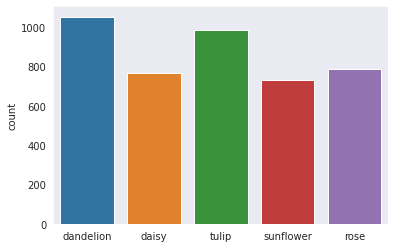

In [10]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

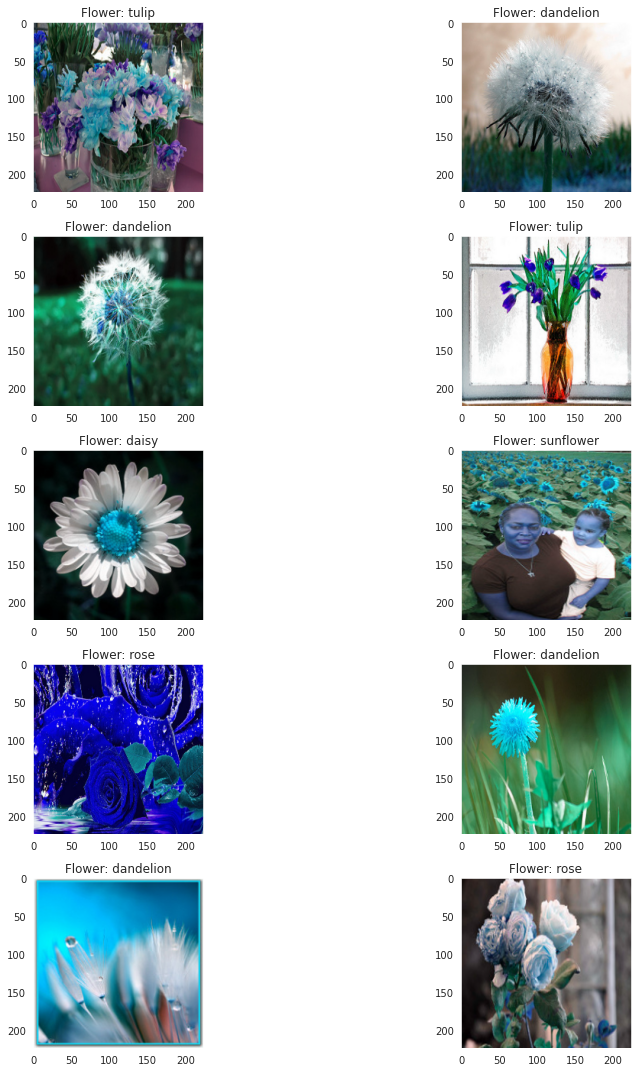

In [11]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [12]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [13]:
# Normalize the data
x = np.array(x) / 255

In [14]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, image_size, image_size, 3)
y = np.array(y)

In [15]:
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [16]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

In [17]:
del x,y,data

## Training The Model

In [18]:
pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

    model = Sequential([
    pre_trained_model,
    Dense(32, activation='relu'),
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dense_36 (Dense)             (None, 7, 7, 32)          16416     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 1445      
Total params: 20,042,245
Trainable params: 4,737,477
Non-trainable params: 15,304,768
_________________________________________________________________


In [19]:
learning_rate_reduction = ReduceLROnPlateau(
                         monitor='val_accuracy', 
                         patience = 2, 
                         verbose=1,
                         factor=0.3, 
                         min_lr=0.000001)

In [20]:
history = model.fit(x_train,
                    y_train, 
                    batch_size = 64 , 
                    epochs = 12 , 
                    validation_data = (x_test, y_test),
                    callbacks = [learning_rate_reduction])

Epoch 1/12
54/54 [==============================] - 32s 373ms/step - loss: 0.8570 - accuracy: 0.6777 - val_loss: 0.5846 - val_accuracy: 0.7824
Epoch 2/12
54/54 [==============================] - 10s 193ms/step - loss: 0.4026 - accuracy: 0.8566 - val_loss: 0.4251 - val_accuracy: 0.8461
Epoch 3/12
54/54 [==============================] - 10s 193ms/step - loss: 0.2553 - accuracy: 0.9065 - val_loss: 0.4976 - val_accuracy: 0.8333
Epoch 4/12
54/54 [==============================] - 10s 192ms/step - loss: 0.1525 - accuracy: 0.9516 - val_loss: 0.4615 - val_accuracy: 0.8565
Epoch 5/12
54/54 [==============================] - 10s 190ms/step - loss: 0.0933 - accuracy: 0.9670 - val_loss: 0.5195 - val_accuracy: 0.8484
Epoch 6/12
54/54 [==============================] - 10s 191ms/step - loss: 0.0689 - accuracy: 0.9818 - val_loss: 0.7018 - val_accuracy: 0.8287

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/12
54/54 [==============================] - 10s 191ms

In [21]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

27/27 [==============================] - 2s 76ms/step - loss: 0.6045 - accuracy: 0.8646
Loss of the model is -  0.6045106053352356
27/27 [==============================] - 2s 75ms/step - loss: 0.6045 - accuracy: 0.8646
Accuracy of the model is -  86.45833134651184 %


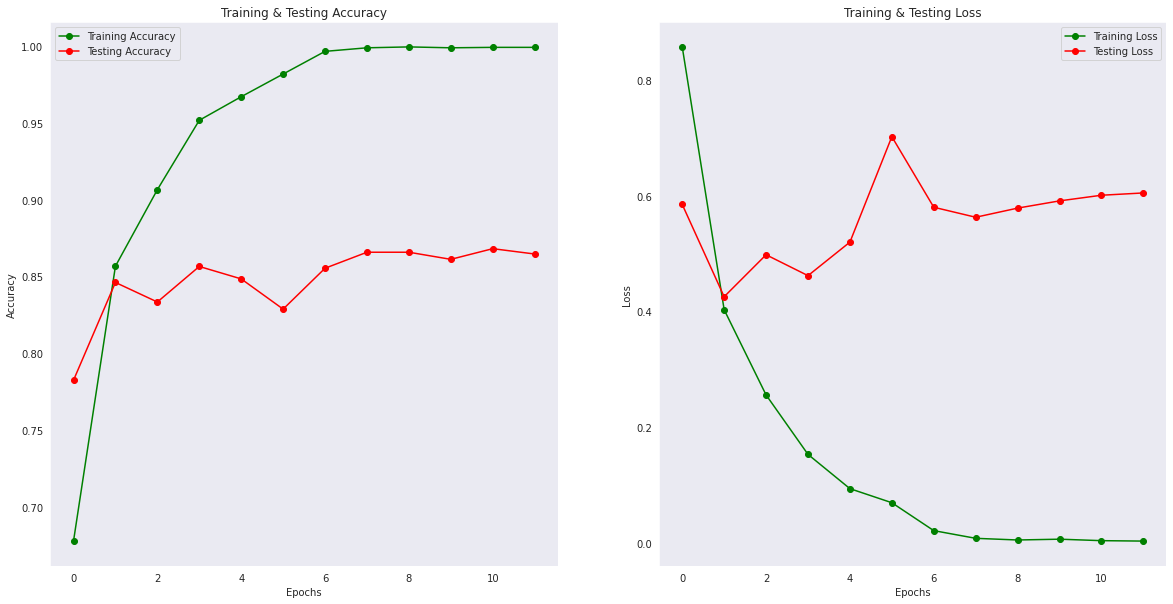

In [22]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [23]:
predictions = model.predict(x_test)
predictions.shape

(864, 5)

In [24]:
y_pred_classes = predictions.argmax(axis = 1)
y_pred_classes.shape

(864,)

In [25]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # set the size of the figure here
    plt.figure(figsize=(15,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80) # set x-axis text angle here
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [27]:
class_dict = {
    'dandelion': 0,
    'daisy':1,
    'tulip':2,
    'sunflower':3,
    'rose':4}

# Get a list of the dict keys.
cols = class_dict.keys()

In [28]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(y_pred_classes, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[221   0   0   0   0]
 [  0 140   0   0   0]
 [  0   0 189   0   0]
 [  0   0   0 149   0]
 [  0   0   0   0 165]]


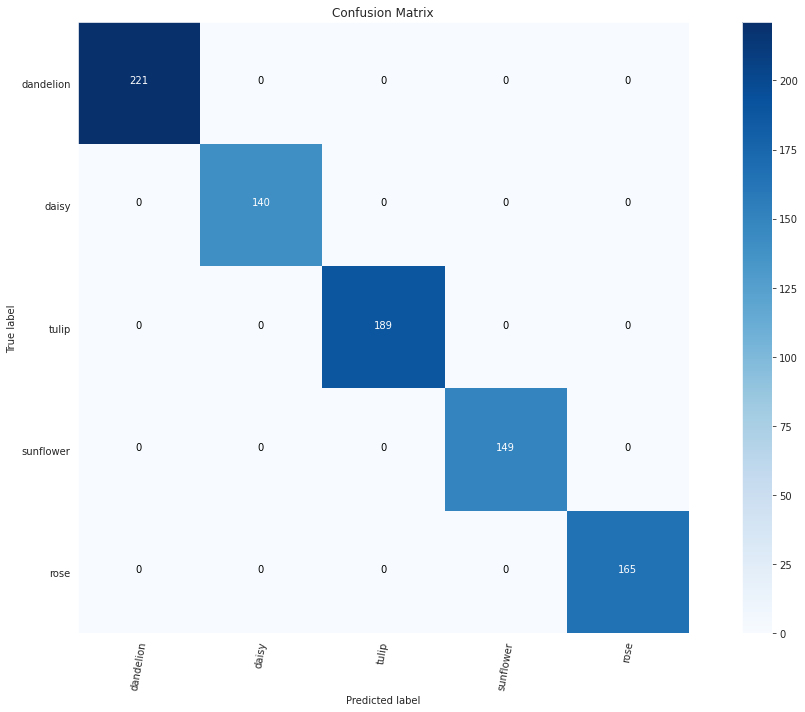

In [29]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = cols

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [30]:
print(classification_report(y_test_inv, y_pred_classes, target_names = labels))

              precision    recall  f1-score   support

   dandelion       0.89      0.93      0.91       210
       daisy       0.91      0.83      0.87       153
       tulip       0.84      0.81      0.82       197
   sunflower       0.89      0.90      0.90       147
        rose       0.80      0.84      0.82       157

    accuracy                           0.86       864
   macro avg       0.87      0.86      0.86       864
weighted avg       0.87      0.86      0.86       864



In [31]:
model.save('my_flowers.h5')

In [32]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_flowers')

In [33]:
saved_model_dir = ('./saved_model/my_flowers') 
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)